# Final Project - Linear Regression

The following project report was written to satisfy the requirements of the final project for the Coursera [Supervised Machine Learning: Regression ](https://www.coursera.org/learn/supervised-machine-learning-regression/home/welcome) course by [IBM](ibm.com). It closely follows the materials outlined in the course including worked examples. 

Please read the final report in this repository for explanation of this code. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read data and get basic descriptions

In [2]:
import os
data_path = ['data']
# Import the data using the file path
filepath = os.sep.join(data_path + ['insurance.csv'])
data = pd.read_csv(filepath, sep=',')

print(data.shape)

(1338, 7)


In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.dtypes.value_counts()

object     3
float64    2
int64      2
dtype: int64

In [5]:
data.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [6]:
data.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

### now begin basic feature engineering

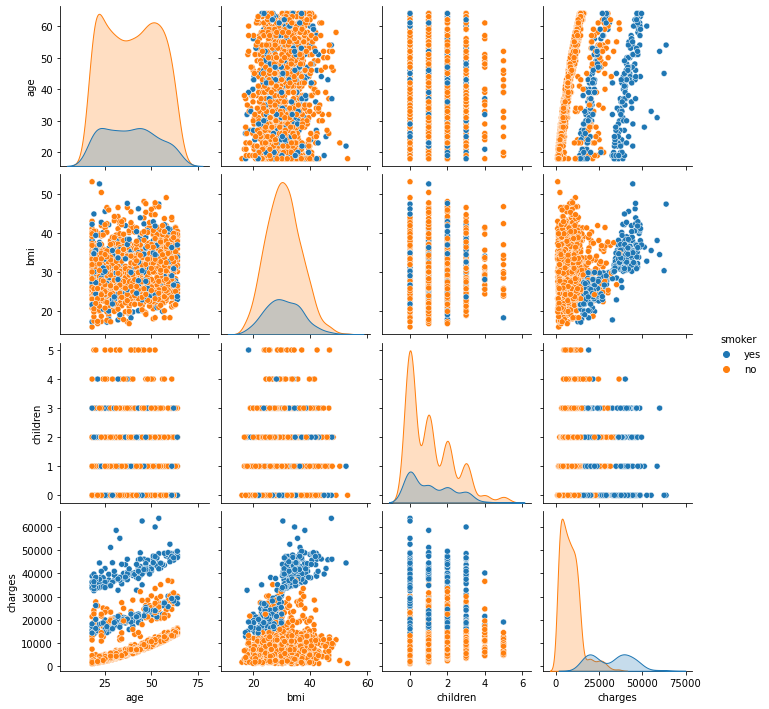

In [7]:
sns.pairplot(data, hue='smoker')

In [8]:
mask = data.dtypes == np.object
categorical_cols = data.columns[mask]
categorical_cols

Index(['sex', 'smoker', 'region'], dtype='object')

In [9]:
mask = data.dtypes != np.object
numerical_cols = data.columns[mask]
numerical_cols

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

In [10]:
# deskew columns with higher skew
skew_columns = (data[numerical_cols]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
print(skew_columns)

for col in skew_columns.index.tolist():
    data[col] = np.log1p(data[col])

charges     1.51588
children    0.93838
dtype: float64


In [11]:
# determine feature and target column names
y_col = 'charges'
numeric_features = [x for x in numerical_cols if x != y_col]
categorical_features = categorical_cols

In [12]:
# split into X and Y
from sklearn.model_selection import train_test_split
y=data['charges']
X=data.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)


In [13]:
numeric_features

['age', 'bmi', 'children']

### Perform linear regression with onehot encoding and polynomical features for baseline

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


n_deg = 2 # degree of polynomial transformation for numeric features

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=n_deg)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  LinearRegression())])


clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 st

In [16]:
# Extract feature names for analysis
cat_feature_names = clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

# for some reason, I cannot access the numeric_feature names from pipeline --> create workaround to get names 
poly_dummy = PolynomialFeatures(degree=n_deg)
num_feature_names = poly_dummy.fit(X_train[numeric_features], 1).get_feature_names(numeric_features)

feature_names = [*num_feature_names, *cat_feature_names] 
print(feature_names)

['1', 'age', 'bmi', 'children', 'age^2', 'age bmi', 'age children', 'bmi^2', 'bmi children', 'children^2', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']


In [17]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

R2 = r2_score(y_test_pred,y_test)

print('Training Error:', mean_squared_error(y_train, y_train_pred))
print('Test Error:',mean_squared_error(y_test, y_test_pred))
print('R2:',R2)

Training Error: 0.1856933348026377
Test Error: 0.19896571610056102
R2: 0.7079399783671059


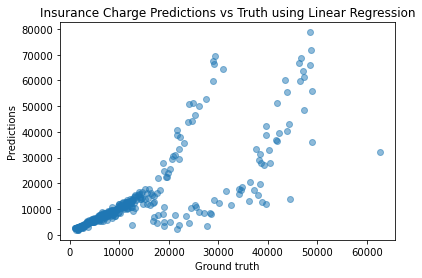

In [18]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(np.expm1(y_test), np.expm1(y_test_pred), alpha=.5)
ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Insurance Charge Predictions vs Truth using Linear Regression');


In [19]:
coef = clf.named_steps['regressor'].coef_

Coefs = pd.DataFrame(list(zip(feature_names, coef)),columns = ['Feature', 'Coef']).T
Coefs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Feature,1,age,bmi,children,age^2,age bmi,age children,bmi^2,bmi children,children^2,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
Coef,0,0.644289,0.51987,0.238473,-0.115501,-0.00454132,-0.191719,-0.426157,-0.00351053,0.0602686,0.0404959,-0.0404959,-0.776095,0.776095,0.114363,0.0231938,-0.0846527,-0.0529046


## Train 3 Models 
## Linear regression with k-fold validation

In [20]:
from sklearn.linear_model import  Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict

kf = KFold(shuffle=True, random_state=72018, n_splits=3)

clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear_regression',  LinearRegression())])

params = {}

grid = GridSearchCV(clf_lr, params, cv=kf)
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                  

In [25]:
y_predict = grid.predict(X)
r2_score(y, y_predict)


0.7772241104233573

In [26]:
grid.best_score_, grid.best_params_

(0.7702366965813309, {})

In [27]:
coef = grid.best_estimator_.named_steps['linear_regression'].coef_

Coefs = pd.DataFrame(list(zip(feature_names, coef)),columns = ['Feature', 'Coef']).T
Coefs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Feature,1,age,bmi,children,age^2,age bmi,age children,bmi^2,bmi children,children^2,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
Coef,0,0.78656,0.365062,0.265667,-0.207832,-0.0523753,-0.226196,-0.266833,0.039127,0.0183293,0.0404753,-0.0404753,-0.778014,0.778014,0.0884451,0.0193236,-0.062722,-0.0450467


## Ridge regression

In [28]:
from sklearn.linear_model import  Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict

kf = KFold(shuffle=True, random_state=72018, n_splits=3)

clf_2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('ridge_regression',  Ridge())])

params = {
    'ridge_regression__alpha': np.geomspace(1, 20, 30)
}

grid = GridSearchCV(clf_2, params, cv=kf)
grid.fit(X, y)



GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                  

In [29]:
grid.best_score_, grid.best_params_

(0.7706003873247802, {'ridge_regression__alpha': 1.8585687035693255})

In [31]:
y_predict = grid.predict(X)
r2_score(y, y_predict)


0.7770576817610768

In [32]:
coef = grid.best_estimator_.named_steps['ridge_regression'].coef_

Coefs = pd.DataFrame(list(zip(feature_names, coef)),columns = ['Feature', 'Coef']).T
Coefs


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Feature,1,age,bmi,children,age^2,age bmi,age children,bmi^2,bmi children,children^2,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
Coef,0,0.706294,0.310332,0.254722,-0.154566,-0.0224745,-0.217947,-0.227393,0.0458477,0.0177233,0.0401677,-0.0401677,-0.774644,0.774644,0.0875721,0.0194722,-0.0622485,-0.0447959


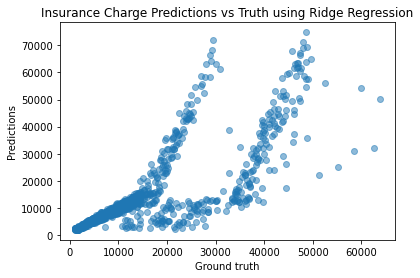

In [33]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(np.expm1(y), np.expm1(y_predict), alpha=.5)
ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Insurance Charge Predictions vs Truth using Ridge Regression');

## Lasso

In [34]:
from sklearn.linear_model import  Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict

kf = KFold(shuffle=True, random_state=72018, n_splits=3)

clf_3 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Lasso_regression',  Lasso(max_iter=10000))])

params = {
    'Lasso_regression__alpha': np.geomspace(0.0001, 5, 100)
}

grid = GridSearchCV(clf_3, params, cv=kf)
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                  

In [35]:
grid.best_score_, grid.best_params_

(0.7705098268391012, {'Lasso_regression__alpha': 0.0005746845156864445})

In [36]:
y_predict = grid.predict(X)
r2_score(y, y_predict)

0.7769817610895499

In [261]:
coef = grid.best_estimator_.named_steps['Lasso_regression'].coef_

Coefs = pd.DataFrame(list(zip(feature_names, coef)),columns = ['Feature', 'Coef']).T
Coefs


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Feature,1,age,bmi,children,age^2,age bmi,age children,bmi^2,bmi children,children^2,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
Coef,0,0.702209,0.284255,0.261966,-0.157766,-0.0142811,-0.213017,-0.203622,0.0362862,0.0145378,0.0782677,-0,-1.55192,8.57288e-14,0.124073,0.0563714,-0.0221005,-0.00348932


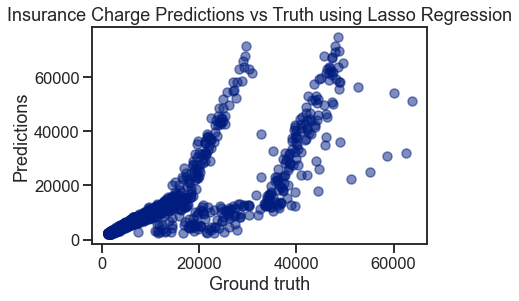

In [262]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(np.expm1(y), np.expm1(y_predict), alpha=.5)
ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Insurance Charge Predictions vs Truth using Lasso Regression');

## Additional analysis to dected source of errors

In [37]:
# add prediction to original dataframe
data2 = data.copy()
data2['charges_pred_lasso'] =  np.expm1(y_predict)
data2['charges'] =  np.expm1(data2['charges'])

data2.head()



,age,sex,bmi,children,smoker,region,charges,charges_pred_lasso
0,19,female,27.900,0.000000,yes,southwest,16884.92400,11973.398340
1,18,male,33.770,0.693147,no,southeast,1725.55230,3135.453423
2,28,male,33.000,1.386294,no,southeast,4449.46200,5626.985122
3,33,male,22.705,0.000000,no,northwest,21984.47061,4054.937278
4,32,male,28.880,0.000000,no,northwest,3866.85520,4370.776577


<AxesSubplot:xlabel='charges', ylabel='charges_pred_lasso'>

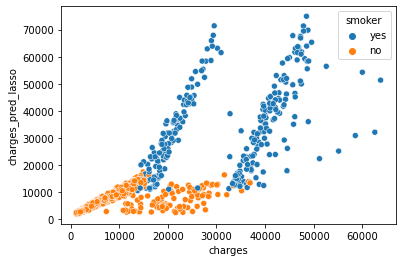

In [38]:
sns.scatterplot(data=data2, x="charges", y="charges_pred_lasso",hue = 'smoker')


<AxesSubplot:xlabel='charges', ylabel='charges_pred_lasso'>

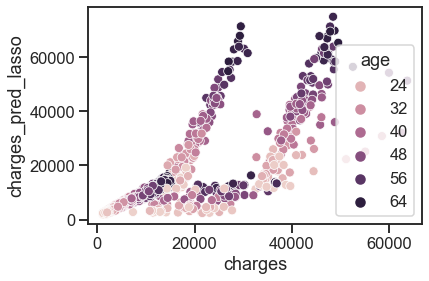

In [275]:
sns.scatterplot(data=data2, x="charges", y="charges_pred_lasso",hue = 'age')

<AxesSubplot:xlabel='charges', ylabel='charges_pred_lasso'>

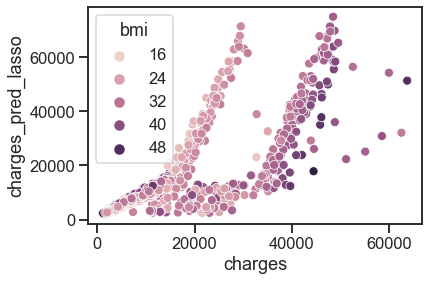

In [276]:
sns.scatterplot(data=data2, x="charges", y="charges_pred_lasso",hue = 'bmi')

C:\Users\tobia\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\tobia\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


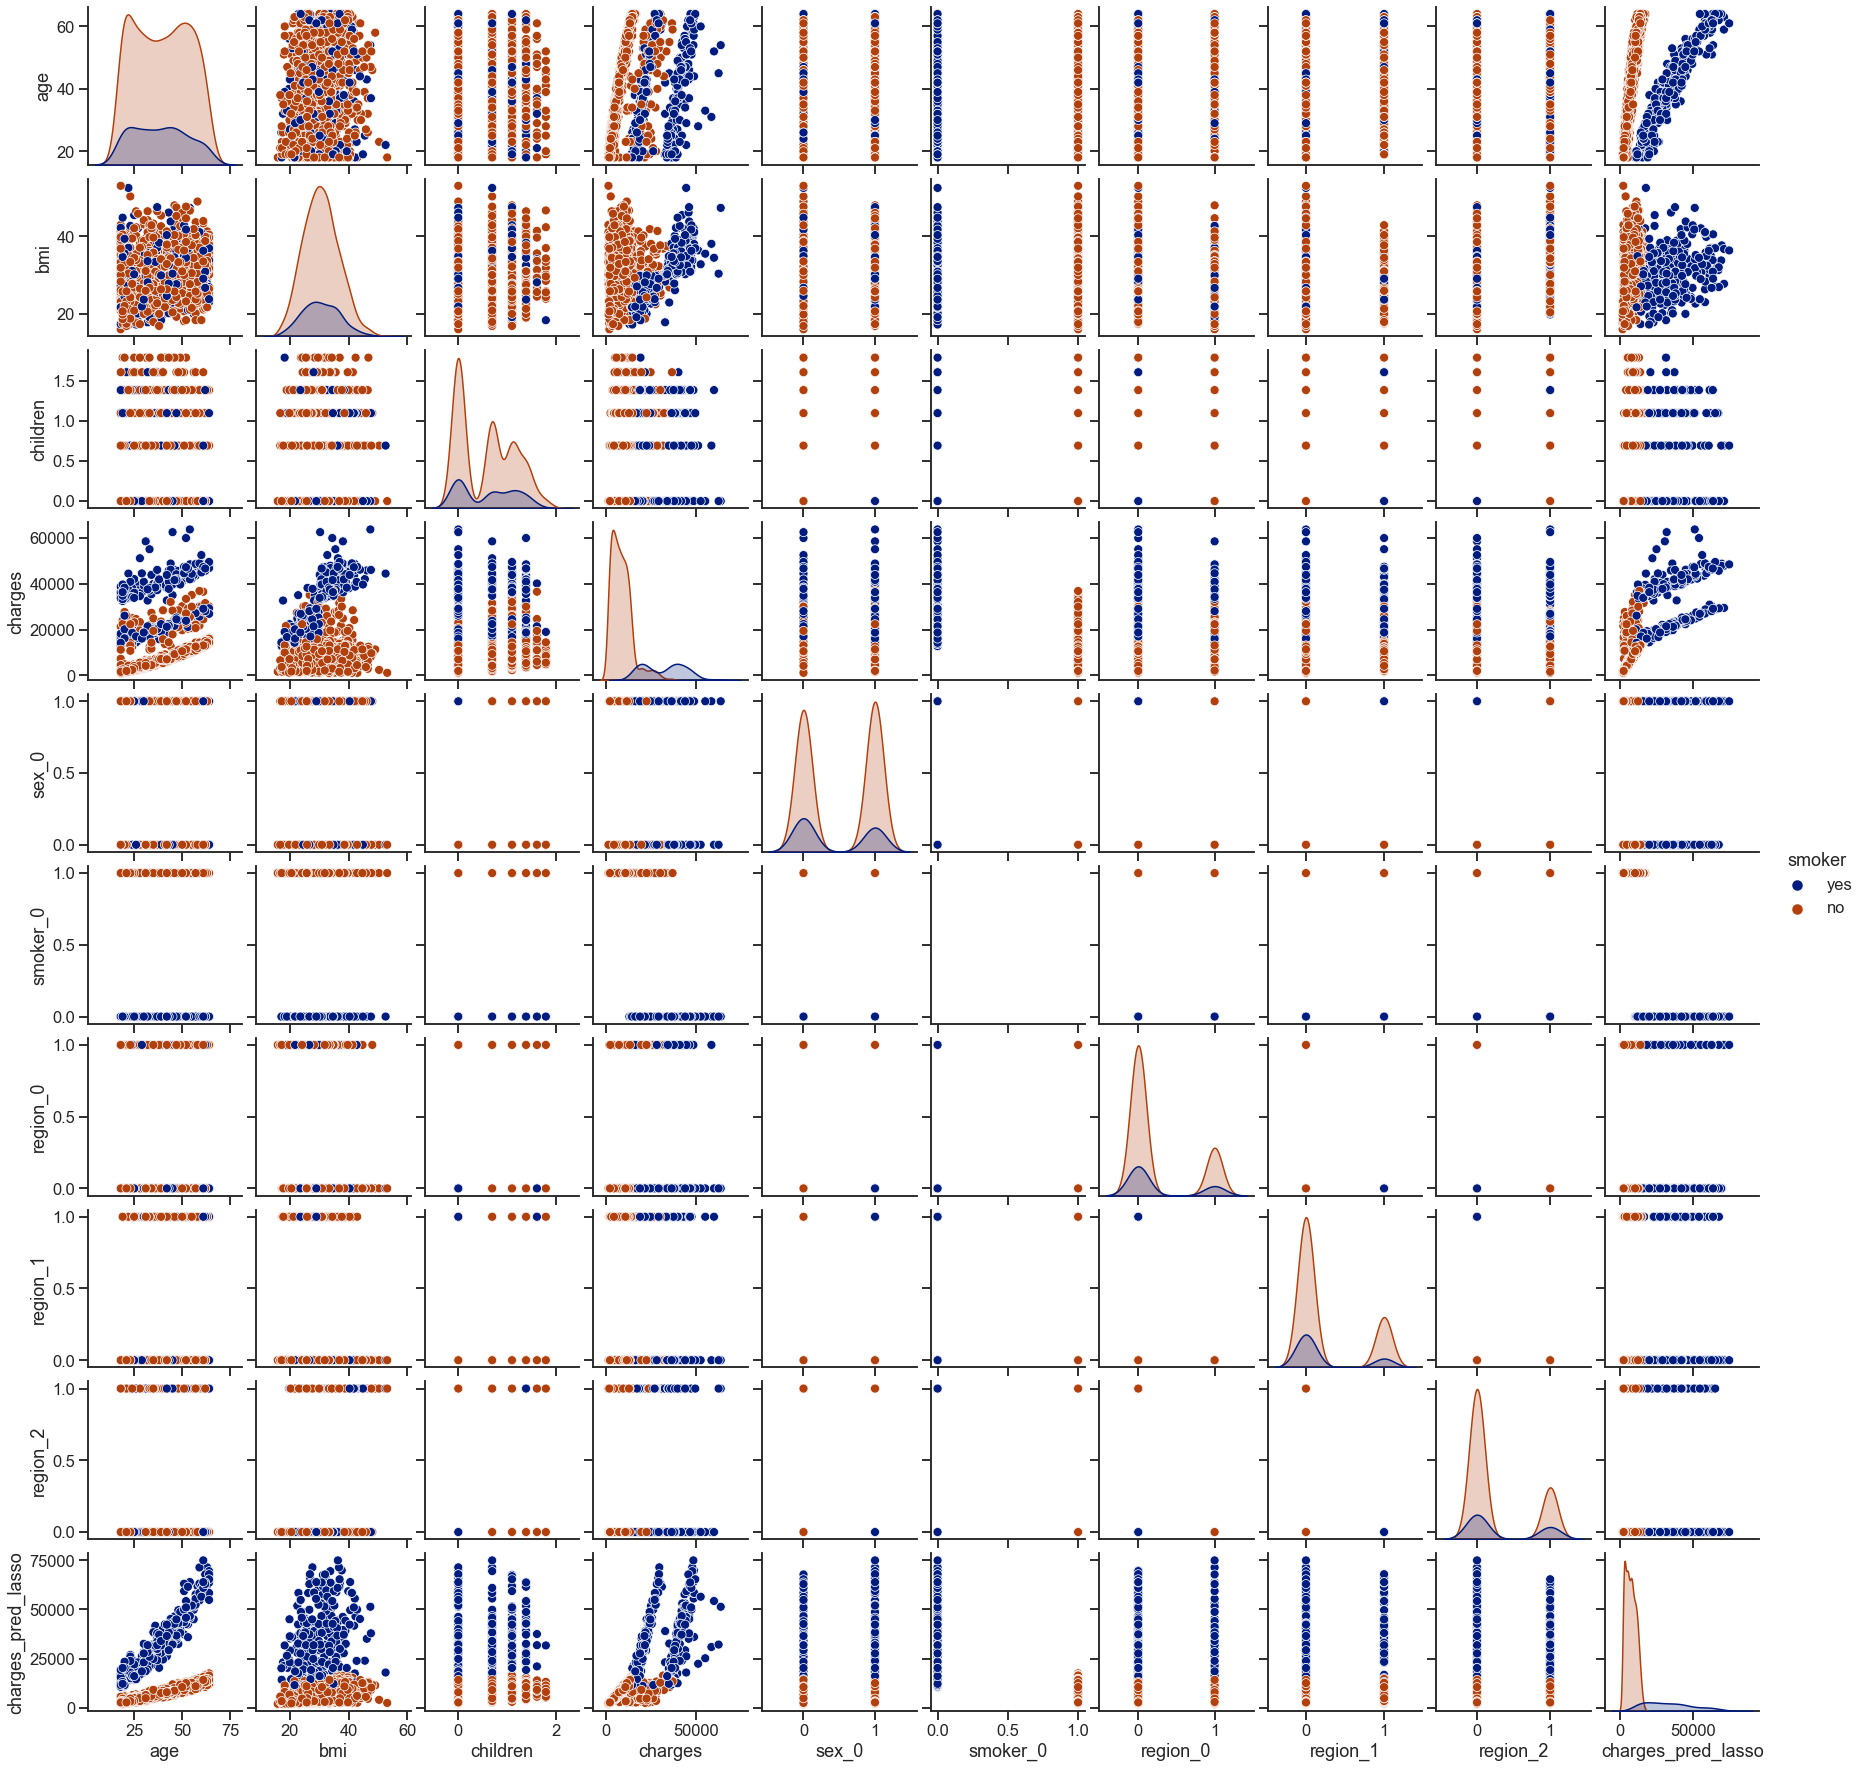

In [269]:
sns.pairplot(data2, hue='smoker')

In [101]:
transformer.transformers_[0][0].named_steps

AttributeError: 'str' object has no attribute 'named_steps'

In [71]:
X_test = transformer.transform(X_test)

In [67]:
X_train.shape

(936, 45)

In [81]:



LR = LinearRegression()
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [82]:
 mean_squared_error(y_train, y_train_pred)

0.1340580538185338

In [83]:
 mean_squared_error(y_test,  y_test_pred)

0.13006534696317854

In [84]:
r2_score(y_test_pred,y_test)

0.8176849632587349

In [90]:
LR.coef_

array([ 6.75408421e+07,  4.58704353e-01,  8.20720678e-02,  1.29314514e-01,
       -1.35027490e+10,  1.06534677e+11,  6.14038438e+11,  9.59343074e+10,
        4.98298784e+11, -2.67417042e-02, -1.54367092e-02, -7.65793444e-02,
       -2.97969304e-02,  1.84409593e-01, -5.50692618e-02, -4.20049505e-02,
        4.74259867e-03, -2.24319670e-02, -5.76230289e-03,  2.18962740e-04,
       -1.17858407e-01,  1.36564902e-02, -5.65467789e-03, -5.87659163e-03,
       -1.69767654e-03,  3.98358350e-03,  6.71203007e-02,  2.33698470e-02,
        2.66274691e-02,  2.13335290e-02,  2.63217036e+11,  2.24207972e-02,
        1.04580363e-02, -3.60754527e-03,  2.40727404e-03,  7.41693988e+10,
        3.27314868e-02,  1.81158278e-02,  4.20527789e-03, -4.82642802e+11,
       -4.84996125e+11,  5.17525275e+11, -2.11070295e+11,  1.77317459e+11,
       -1.02167721e+11])

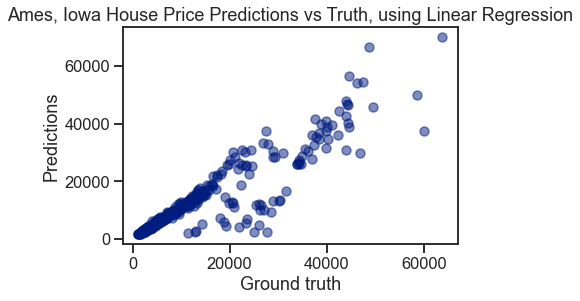

In [79]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(np.expm1(y_test), np.expm1(y_test_pred), alpha=.5)
ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Insurance Charge Predictions vs Truth using Linear Regression');



### Now do Lasso and Ridge Regression

In [140]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({'brand': ['aaaa', 'asdfasdf', 'sadfds', 'NaN'],
                   'category': ['asdf', 'asfa', 'asdfas', 'as'],
                   'num1': [1, 1, 0, 0],
                   'num2': [1.4, 1, 0.58, 0],
                   'target': [0.2, 0.11, 1.34, 1.123]})

numeric_features = ['num1','num2']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())])

categorical_features = ['brand', 'category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  LinearRegression())])

clf.fit(df.drop('target', 1), df['target'])

clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)



array(['brand_NaN', 'brand_aaaa', 'brand_asdfasdf', 'brand_sadfds',
       'category_as', 'category_asdf', 'category_asdfas', 'category_asfa'],
      dtype=object)

In [146]:
clf.fit(df.drop('target', 1), df['target'])
clf.named_steps['preprocessor'].transformers[0][1].named_steps['poly'].get_feature_names(numeric_features)

NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [169]:
X_trains = preprocessor.fit_transform(df.drop('target', 1))
pd.DataFrame(X_trains)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,1.0,1.262713,1.0,1.297771,1.518520,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.491591,1.0,0.648886,0.235151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-1.0,-0.318088,-1.0,-0.973329,-0.651978,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,-1.0,-1.436215,-1.0,-0.973329,-1.101692,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [166]:
preprocessor.fit(df.drop('target', 1))
preprocessor.transformers[0][1].named_steps['poly'].get_feature_names([numeric_features])

NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [170]:
df.drop('target', 1)

,brand,category,num1,num2
0,aaaa,asdf,1,1.40
1,asdfasdf,asfa,1,1.00
2,sadfds,asdfas,0,0.58
3,NaN,as,0,0.00


In [182]:
poly = PolynomialFeatures(degree=2)
poly.fit(df[numeric_features], 1).get_feature_names(numeric_features)
#poly.get_feature_names(numeric_features)

['1', 'num1', 'num2', 'num1^2', 'num1 num2', 'num2^2']

In [164]:
df[numeric_features]

,num1,num2
0,1,1.40
1,1,1.00
2,0,0.58
3,0,0.00
